In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [82]:
from pandas import read_csv
from datetime import datetime
# load data

def parse(*args): 
    return datetime.strptime(str(args[0])+ " " + str(args[1]) , '%d/%m/%Y %H:%M:%S')
dataset = read_csv('/content/drive/My Drive/originaldataset/O3(CPCB) - O3 (1) (1) (1).csv', index_col=0)
#print( dataset.head())
#dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['O3(SENSOR)']
dataset.index.name = 'DATE'
# mark all NA values with 0
# dataset['DATE'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('/content/drive/My Drive/originaldataset/O3(CPCB) - O3 (1) (1) (1).csv')

                     O3(SENSOR)
DATE                           
2020-04-08 08:30:00       14.90
2020-04-08 08:45:00       15.50
2020-04-08 09:00:00       16.50
2020-04-08 09:15:00       33.44
2020-04-08 09:30:00       17.60


In [83]:
cd /content/drive/My Drive/

/content/drive/My Drive


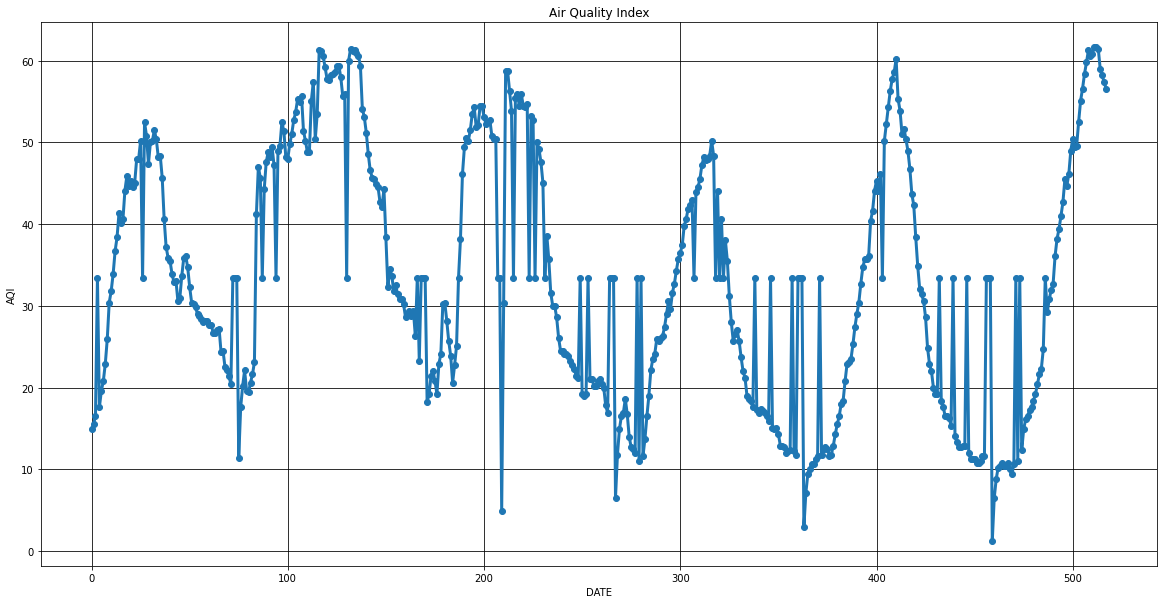

In [84]:
from pandas import read_csv
import matplotlib.pyplot as plt

from matplotlib import pyplot
import pandas as pd
# load dataset
dataset =pd.read_csv('/content/drive/My Drive/originaldataset/O3(CPCB) - O3 (1) (1) (1).csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
# groups = [1]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()


plt.figure(figsize=(20,10))
plt.xlabel("DATE")
plt.ylabel("AQI")
plt.title('Air Quality Index')
plt.plot(values, marker='o', label='Air Quality Index', linewidth=3)
plt.grid(color='black')

In [85]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i));  #      print(df.shift(-i).head())
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('/content/drive/My Drive/originaldataset/O3(CPCB) - O3 (1) (1) (1).csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#print(scaled[:5])
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
# print(reframed.head())
# reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
# print(reframed.head())

In [86]:
train=0.97
test=0.03
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0]*train)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(train_y[:5])

(501, 1, 1) (501, 1) (16, 1, 1) (16, 1)


In [87]:

from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
11/11 - 0s - loss: 0.4655 - val_loss: 0.7884
Epoch 2/100
11/11 - 0s - loss: 0.3671 - val_loss: 0.6723
Epoch 3/100
11/11 - 0s - loss: 0.2885 - val_loss: 0.5639
Epoch 4/100
11/11 - 0s - loss: 0.2279 - val_loss: 0.4598
Epoch 5/100
11/11 - 0s - loss: 0.1803 - val_loss: 0.3675
Epoch 6/100
11/11 - 0s - loss: 0.1566 - val_loss: 0.3001
Epoch 7/100
11/11 - 0s - loss: 0.1459 - val_loss: 0.2521
Epoch 8/100
11/11 - 0s - loss: 0.1394 - val_loss: 0.2210
Epoch 9/100
11/11 - 0s - loss: 0.1366 - val_loss: 0.1972
Epoch 10/100
11/11 - 0s - loss: 0.1343 - val_loss: 0.1850
Epoch 11/100
11/11 - 0s - loss: 0.1332 - val_loss: 0.1677
Epoch 12/100
11/11 - 0s - loss: 0.1270 - val_loss: 0.1603
Epoch 13/100
11/11 - 0s - loss: 0.1220 - val_loss: 0.1461
Epoch 14/100
11/11 - 0s - loss: 0.1204 - val_loss: 0.1413
Epoch 15/100
11/11 - 0s - loss: 0.1135 - val_loss: 0.1343
Epoch 16/100
11/11 - 0s - loss: 0.1132 - val_loss: 0.1257
Epoch 17/100
11/11 - 0s - loss: 0.1101 - val_loss: 0.1160
Epoch 18/100
11/11 - 0s

In [88]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[2]))

In [89]:
print(test_X.shape)
print(train_X.shape)



(16, 1, 1)
(501, 1, 1)


In [90]:
yhat = model.predict(test_X)
#yhat = model.predict(train_X)
print(yhat[:5])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
print(test_y[:,-1:])
#print(train_y[:,-1:])
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = concatenate((yhat, train_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat[:5])
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
#train_y = train_y.reshape((len(train_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y[:5])
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



[[0.74363315]
 [0.7468792 ]
 [0.7941847 ]
 [0.8369678 ]
 [0.86180735]]
[[0.79999995]
 [0.8479339 ]
 [0.890909  ]
 [0.9157024 ]
 [0.94545454]
 [0.968595  ]
 [0.99338835]
 [0.98181814]
 [0.98512393]
 [0.99999994]
 [0.99999994]
 [0.99669415]
 [0.95537186]
 [0.94214875]
 [0.92892563]
 [0.9157024 ]]
[46.189808 46.386192 49.248177 51.836555 53.339344]
[49.6 52.5 55.1 56.6 58.4]
Test RMSE: 3.939


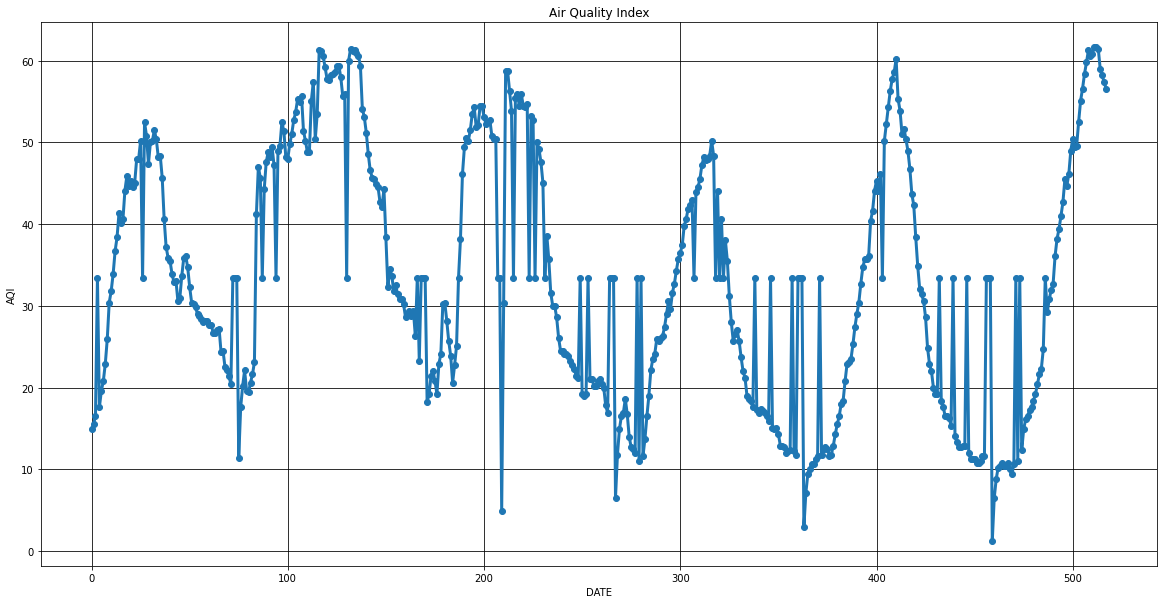

In [91]:
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
# load dataset
dataset =pd.read_csv('/content/drive/My Drive/originaldataset/O3(CPCB) - O3 (1) (1) (1).csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
# groups = [1]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()


plt.figure(figsize=(20,10))
plt.xlabel("DATE")
plt.ylabel("AQI")
plt.title('Air Quality Index')
plt.plot(values, marker='o', label='Air Quality Index', linewidth=3)
plt.grid(color='black')

In [92]:

inv_y[:15]

array([49.6     , 52.5     , 55.1     , 56.6     , 58.4     , 59.8     ,
       61.299995, 60.6     , 60.8     , 61.699997, 61.699997, 61.499996,
       59.      , 58.2     , 57.4     ], dtype=float32)

In [93]:
inv_yhat[:15]


array([46.189808, 46.386192, 49.248177, 51.836555, 53.339344, 55.151733,
       56.56808 , 58.092045, 57.38004 , 57.58333 , 58.499554, 58.499554,
       58.295746, 55.758022, 54.94988 ], dtype=float32)

In [95]:
import pandas as pd
import openpyxl

df = pd.DataFrame([46.386192, 49.248177, 51.836555, 53.339344, 55.151733,
       56.56808 , 58.092045, 57.38004 , 57.58333 , 58.499554, 58.499554,
       58.295746, 55.758022, 54.94988],
                   columns=['a'])

print(df)
df.to_excel('pandas_to_excel.xlsx', sheet_name='new_sheet_name')

            a
0   46.386192
1   49.248177
2   51.836555
3   53.339344
4   55.151733
5   56.568080
6   58.092045
7   57.380040
8   57.583330
9   58.499554
10  58.499554
11  58.295746
12  55.758022
13  54.949880
